In [1]:
#!/usr/bin/env python
#-------------------------------------------------------------------------
# Filename: main.py
#  Purpose: Main scripts to do the processing of the data
#           uses preprocessed data to calculate estimations of 
#           phase velocities and backazimuths, write results 
#           plotting figures, writing results to a file. Uses 
#           the module "rolode" which can be found in the file "rolode.py"
#   Author: Alexander Wietek
#    Email: alexander.wietek@mytum.de
#
# Copyright (C) 2013 Alexander Wietek
#-------------------------------------------------------------------------
#
#  I modify the main program such that we do the preprocessing via SeisHub
#  and use the results directly
#
#  Author: Joachim Wassermann (2013)
#-------------------------------------------------------------------------

import os
import matplotlib
#matplotlib.use('agg')
from obspy import *
#from obspy.clients.fdsn import Client
from obspy.clients.filesystem.sds import Client
import obspy.signal.array_analysis as AA
import numpy as np
import rochade2 as rochade
import pickle
import scipy as sp
#import gaussianfilt
#import tilt
from obspy.core import AttribDict
from obspy.signal.rotate import rotate2zne


def notch(trace,f_cut):
    wn = f_cut/trace.stats.sampling_rate    
    r = 0.99
    B, A = np.zeros(3), np.zeros(3)
    A[0],A[1],A[2] = 1.0, -2.0*r*np.cos(2*np.pi*wn), r*r
    B[0],B[1],B[2] = 1.0, -2.0*np.cos(2*np.pi*wn), 1.0
    trace.data = sp.signal.lfilter(B, A, trace.data, axis=0)


In [2]:
## # Set parameters here:
###################################################################
# Data Base
#Data structure has to be: /STATIONNAME/YEAR/NETWORK/STATION/COMPONENT/mseeds
#for example: /FINM1/2023/XX/FINM1/HHZ.D/XX.FINM1..HHZ.D.2023.041
client = Client('/Documents/PhD/Daten/ROLODE/FINM1')
#client2 = Client("IRIS")
sstation = 'IV.FINM1..HH*' #station name translational data
rstation = 'IV.FINM1..HJ*' #station name rotational data

vmin=50
vmax=2000

#define start and end time of your data
start  = UTCDateTime("2023-10-17T01:00:00.00") 
starty = start
endy   =UTCDateTime("2023-10-17T03:00:00.00")

love_only = False

periods_per_window = 10. #8
# Specify frequency bands here
f_min =1.   # smallest frequency to process
f_max = 20.  # highest frequency to process
f_space = 0.1            
bandwidth = 0.1   # Bandwidth of bandpass filter  


# Set method for weighing the time windows. Can be one of 
#    "standard" ... wght = np.sum(rotrate**2)/(err)
#    "normed"   ... wght = (1 - err/np.sum(rotrate**2)^exp)
#    "uniform"  ... wght = 1
wghtmethod = "normed"
mvalue=3.e-10
#mvalue=-1
exp = 0.3 # exponent of normed weights
df = 100. # common sampling rate to resample the data 
body = False
detrigger = False   

#parameters for trigger if detrigger = True
tsta = 1.5
tlta = 10.
thres1=2.8   
thres2=0.5
pre = 2.
post = 10.


In [4]:
# The lowpass and highpass frequencies for bandpass filtering
f_lower = []
f_higher = []
fcenter = f_max
first = True


#we try half octave band filtering
while fcenter > f_min:
    f_l = fcenter/(np.sqrt(np.sqrt(2.)))
    f_u = fcenter*(np.sqrt(np.sqrt(2.)))
    f_lower.append(f_l)
    f_higher.append(f_u)

    fcenter = fcenter/(np.sqrt(2.))
    print(fcenter)
    
#we try quarter octave band filtering
#while fcenter > f_min:
   #f_l = fcenter/(np.sqrt(np.sqrt(np.sqrt(2.))))
   #f_u = fcenter*(np.sqrt(np.sqrt(np.sqrt(2.))))
   #f_lower.append(f_l)
   #f_higher.append(f_u)

   #fcenter = fcenter/(np.sqrt(np.sqrt(2.)))
   #print(fcenter)

f_lower = np.asarray(f_lower)
f_higher = np.asarray(f_higher)

trigger_params={"sta": tsta,"lta": tlta,"thres_1":thres1,"thres_2": thres2,"pre_t":pre,"post_t":post}
firstRun = True;

end = 0.


14.14213562373095
9.999999999999998
7.071067811865474
4.999999999999998
3.535533905932736
2.4999999999999987
1.7677669529663678
1.2499999999999991
0.8838834764831838


In [4]:
# get the relevant information 
while end < endy:
    tsz = []
    tsn = []
    tse = []
    coo = []
    first = True
    if (endy - start) > 3600:
        end = start + 3600.
    else:
        end = endy
    
    tsz = []
    tsn = []
    tse = []
    coo = []

    net,stat,loc,chan=sstation.split(".")
  
    # import translational data 
    sz1 = client.get_waveforms(network=net,station=stat,location=loc,channel=chan,starttime=start,endtime=end)
    #import response information
    inv=read_inventory('/Documents/PhD/Messungen/Rock_Konzert/RESPONSES/FINM1.xml') #seismometer
    inv2 =read_inventory('/Documents/PhD/Messungen/Rock_Konzert/RESPONSES/BS_FINM1.xml') #blueSeis
    
    sz1.merge(method=1,fill_value='latest')
    sz1.attach_response(inv)
    sz1.detrend("linear")
    sz1.resample(sampling_rate=df,no_filter=False)
    sz1.sort()
    sz1.reverse()
    sz1.rotate(method='->ZNE', inventory=inv, components=['ZNE'])
    
    print("imported components are:", sz1)
    end1 = sz1[0].stats.endtime

    sz1.detrend("linear")
    sz1[0].filter('highpass',freq=0.050,zerophase=True)
    sz1[1].filter('highpass',freq=0.050,zerophase=True)
    sz1[2].filter('highpass',freq=0.050,zerophase=True)

    sz1[0].remove_response(water_level=10, output="VEL")
    sz1[1].remove_response(water_level=10, output="VEL")
    sz1[2].remove_response(water_level=10, output="VEL")
    sz1.detrend("linear")
    
    net,stat,loc,chan=rstation.split(".")
    #import rotational data
    rots = client.get_waveforms(network=net,station=stat,location=loc,channel=chan,starttime=start,endtime=end)

    rots.merge(method=1,fill_value='latest')
    rots.attach_response(inv2)
    rots.rotate(method='->ZNE', inventory=inv2, components=['321'])
    print("Offset vertical: %f"%(rots.select(component="Z")[0].data.mean()) )
    print("Offset East: %f"%(rots.select(component="E")[0].data.mean()) )
    print("Offset North: %f"%(rots.select(component="N")[0].data.mean()) )
    rots.remove_sensitivity()
    rots.detrend("linear")
    #rots.plot()
    
    rots.resample(sampling_rate=df,no_filter=False)
    #rots.interpolate(sampling_rate=df,starttime=start+1)
    end2 = rots[0].stats.endtime
    rots.sort()
    rots.reverse()

    rots.detrend("linear")
    print("rotational components are:",rots)

###############################
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
################################

    if end1 > end2:
      rots.trim(start+1,end2)
      sz1.trim(start+1,end2)
    else:
      rots.trim(start+1,end1)
      sz1.trim(start+1,end1)


# in the folowing we are using horizontal components of velocity and acceleration
# consequently we have to correct them from local tilt effects before using it
# this is done via an estimation of the transferfunction
    #sz1.select(component="N")[0].data = tilt.tiltcorrect(sz1.select(component="N")[0],rots.select(component="E")[0])
    #sz1.select(component="E")[0].data = tilt.tiltcorrect(sz1.select(component="E")[0],rots.select(component="N")[0])

    acc = sz1.copy()
    acc.differentiate()



###################################################################
# Start of calculations ...
###################################################################

    # and the parameter periods_per_window
    windows_l = rochade.rolode_estimator( f_lower, f_higher, periods_per_window,vmin,vmax,trigger_params)
    windows_l.printlog()
    rot = rots.copy()
    #acc.trim(nstart,nend)
    #sz1.trim(nstart,nend)
    #rot.trim(nstart,nend)


####################################################################
## Main processing step, window_estimation takes the 
## vertical rotation rate, north acceleration and east acceleration
## and calculates the estimations - LOVE WAVES
####################################################################
    if body == True:
        irot = rot.copy()
        irot.integrate()
        windows_l.window_estimation_love(irot[0],sz1[1],sz1[2], verbose = True,mask_value=mvalue,body=body,trigger=detrigger)
        #define path where to save output:
        save_path_love = "/ROLODE/FINM1_HH/%s_%02d-%02d%02d-SV/"%(stat,starty.day,endy.day,endy.month)

    else:
        windows_l.window_estimation_love(rot.select(component="Z")[0],acc.select(component="N")[0],acc.select(component="E")[0],verbose = True,mask_value=mvalue,trigger=detrigger)
        save_path_love = "/ROLODE/FINM1_HH/%s_%02d-%02d%02d-Love/"%(stat,starty.day,endy.day,endy.month)
    if not os.path.exists(save_path_love):
       os.makedirs(save_path_love)

    windows_l.write(save_path_love + "windows_l.pkl",firstRun)
    windows_l.writelog(save_path_love + "info_l.log",firstRun)
    
###################################################################
# Main processing step, window_estimation takes the 
# vertical acceleration , north and east rotation rate
# and calculates the estimations - RAYLEIGH WAVES
###################################################################
    if love_only == False:
        windows_r = rochade.rolode_estimator( f_lower, f_higher, periods_per_window,vmin,vmax,trigger_params)
        windows_r.printlog()
        if body == True:
            irot = rot.copy()
            irot.integrate()
            windows_r.window_estimation_rayleigh(sz1[0], irot[1], irot[2], verbose = True,mask_value=mvalue,body=body,trigger=detrigger)
            save_path_ray1 = "/ROLODE/FINM1_HH/%s_%02d-%02d%02d-SV1/"%(stat,starty.day,endy.day,endy.month)
        else:
            windows_r.window_estimation_rayleigh(acc.select(component="Z")[0], rot.select(component="N")[0], rot.select(component="E")[0], verbose = True,mask_value=mvalue,trigger=detrigger)
            save_path_ray1 = "/ROLODE/FINM1_HH/%s_%02d-%02d%02d-Rayleigh/"%(stat,starty.day,endy.day,endy.month,)

        if not os.path.exists(save_path_ray1):
            os.makedirs(save_path_ray1)

        windows_r.write(save_path_ray1 + "windows_r.pkl",firstRun)
        windows_r.writelog(save_path_ray1 + "info_r.log",firstRun)


##################################################################
# Main processing step, window_estimation takes the 
# vertical acceleration , north and east rotation rate
# and calculates the estimations - RAYLEIGH WAVES
###################################################################
    if love_only == False:
        windows_r2 = rochade.rolode_estimator( f_lower, f_higher, periods_per_window,vmin,vmax,trigger_params)
        windows_r2.printlog()
        if body == True:
            irot = rot.copy()
            irot.integrate()
            save_path_ray2 = "/ROLODE/FINM1_HH/%s_%02d-%02d%02d-SV2/"%(stat,starty.day,endy.day,endy.month)
            windows_r2.window_estimation_rayleigh2(sz1,irot.select(component="N")[0],irot.select(component="E")[0],verbose=True,body=body,mask_value=mvalue,trigger=detrigger)
        else:
            save_path_ray2 = "/ROLODE/FINM1_HH/%s_%02d-%02d%02d-Rayleigh2/"%(stat,starty.day,endy.day,endy.month)
            windows_r2.window_estimation_rayleigh2(acc,rot.select(component="N")[0],rot.select(component="E")[0],verbose=True,body=body,mask_value=mvalue,trigger=detrigger)

        if not os.path.exists(save_path_ray2):
            os.makedirs(save_path_ray2)


        windows_r2.write(save_path_ray2 + "windows_r2.pkl",firstRun)
        windows_r2.writelog(save_path_ray2 + "info_r2.log",firstRun)

    firstRun=False
    start = end 

imported components are: 3 Trace(s) in Stream:
IV.FINM1..HHZ | 2023-10-17T01:00:00.000000Z - 2023-10-17T02:00:00.000000Z | 100.0 Hz, 360001 samples
IV.FINM1..HHN | 2023-10-17T01:00:00.000000Z - 2023-10-17T02:00:00.000000Z | 100.0 Hz, 360001 samples
IV.FINM1..HHE | 2023-10-17T01:00:00.000000Z - 2023-10-17T02:00:00.000000Z | 100.0 Hz, 360001 samples
Offset vertical: 50432.295923
Offset East: 162.545519
Offset North: 52650.203702
rotational components are: 3 Trace(s) in Stream:
IV.FINM1..HJZ | 2023-10-17T01:00:00.001000Z - 2023-10-17T01:59:59.991000Z | 100.0 Hz, 360000 samples
IV.FINM1..HJN | 2023-10-17T01:00:00.001000Z - 2023-10-17T01:59:59.991000Z | 100.0 Hz, 360000 samples
IV.FINM1..HJE | 2023-10-17T01:00:00.001000Z - 2023-10-17T01:59:59.991000Z | 100.0 Hz, 360000 samples
--------------------------------------------------------
ROLODE estimator class:
Parameters:
  highpass frequencies:
    [ 18.34008086  15.42210825  12.96839555  10.90507733   9.17004043
   7.71105413   6.48419777   5

In [5]:
###################################################################
# Postprocessing step
##################################################################

# Load windows from file
save_path = save_path_love
winfile = open(save_path + "windows_l.pkl","rb")
windows_l = pickle.load(winfile)
print("open %s"%winfile)
winfile.close()
windows_l.wineval = True

# Calculate means, modes, medians, standard deviations, and set weights
windows_l.set_weights(method = wghtmethod, exp = exp)
#try:
windows_l.calc_mean_std()
#except:
#    pass
    
try:
    windows_l.calc_kde_mode()
except:
    pass
windows_l.calc_median()

# Plot all the histograms for the individual frequencies
try:
    windows_l.plot_histograms(savepath = save_path)
except:
    pass

# Plot the slowness and backazimuth distribution for all frequencies
windows_l.plot_polar(savepath = save_path)

# Plot the dispersion curves with errorbars 
try:
    windows_l.plot_errorbar(savepath = save_path)
except:
    pass
# Write results to a file
try:
    windows_l.writeresults(savepath = save_path)
except:
    pass
print("\n Done Love")
if love_only == True:
   exit
#

open <_io.BufferedReader name='C:\\Users\\Sabrina Keil\\Documents\\PhD\\Results/ROLODE/FINM1_4_HH/FINM1_17-1710-Love/windows_l.pkl'>
Calculating means and standard deviations...

  Now at frequency f = 21.81
  Now at frequency f = 18.34
  Now at frequency f = 15.42
  Now at frequency f = 12.97
  Now at frequency f = 10.91
  Now at frequency f = 9.17
  Now at frequency f = 7.71
  Now at frequency f = 6.48
  Now at frequency f = 5.45
  Now at frequency f = 4.59
  Now at frequency f = 3.86
  Now at frequency f = 3.24
  Now at frequency f = 2.73
  Now at frequency f = 2.29
  Now at frequency f = 1.93
  Now at frequency f = 1.62
  Now at frequency f = 1.36
  Now at frequency f = 1.15
Calculating KDEs and modes:

  Now at frequency f = 20.08
  Now at frequency f = 16.88
  Now at frequency f = 14.20
  Now at frequency f = 11.94
  Now at frequency f = 10.04
  Now at frequency f = 8.44
  Now at frequency f = 7.10
  Now at frequency f = 5.97
  Now at frequency f = 5.02
  Now at frequency f = 4.2

open <_io.BufferedReader name='C:\\Users\\Sabrina Keil\\Documents\\PhD\\Results/ROLODE/FINM1_4_HH/FINM1_17-1710-Rayleigh/windows_r.pkl'>
Calculating means and standard deviations...

  Now at frequency f = 21.81
  Now at frequency f = 18.34
  Now at frequency f = 15.42
  Now at frequency f = 12.97
  Now at frequency f = 10.91
  Now at frequency f = 9.17
  Now at frequency f = 7.71
  Now at frequency f = 6.48
  Now at frequency f = 5.45
  Now at frequency f = 4.59
  Now at frequency f = 3.86
  Now at frequency f = 3.24
  Now at frequency f = 2.73
  Now at frequency f = 2.29
  Now at frequency f = 1.93
  Now at frequency f = 1.62
  Now at frequency f = 1.36
  Now at frequency f = 1.15
Calculating KDEs and modes:

  Now at frequency f = 20.08
  Now at frequency f = 16.88
  Now at frequency f = 14.20
  Now at frequency f = 11.94
  Now at frequency f = 10.04
  Now at frequency f = 8.44
  Now at frequency f = 7.10
  Now at frequency f = 5.97
  Now at frequency f = 5.02
  Now at frequency f =

C:\Users\Sabrina Keil\anaconda3\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
C:\Users\Sabrina Keil\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Sabrina Keil\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Sabrina Keil\Documents\PhD\Programme\rochade2_jo.py:701: UserWarning: Not able to calculate kde ... continuing
  warnings.warn(msg)


  Now at frequency f = 11.94
  Now at frequency f = 10.04
  Now at frequency f = 8.44
  Now at frequency f = 7.10
  Now at frequency f = 5.97
  Now at frequency f = 5.02
  Now at frequency f = 4.22
  Now at frequency f = 3.55
  Now at frequency f = 2.98
  Now at frequency f = 2.51
  Now at frequency f = 2.11
  Now at frequency f = 1.77
  Now at frequency f = 1.49
  Now at frequency f = 1.25
  Now at frequency f = 1.06
Plotting histograms ...


C:\Users\Sabrina Keil\Documents\PhD\Programme\rochade2_jo.py:1014: UserWarning: Nothing to plot...
  warnings.warn(msg)


Plotting Dispersion curve with errorbars


C:\Users\Sabrina Keil\anaconda3\lib\site-packages\numpy\lib\histograms.py:1123: RuntimeWarning: invalid value encountered in true_divide
  hist /= s



 Done Rayleigh


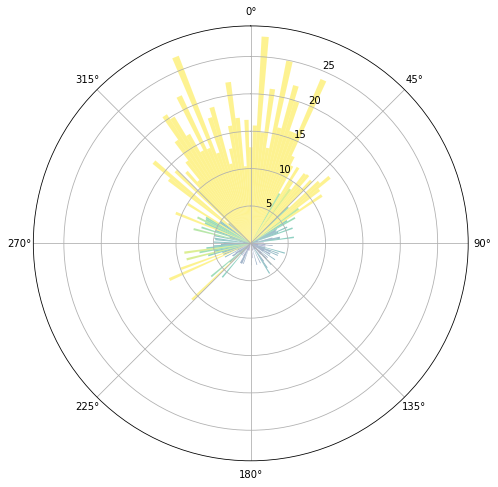

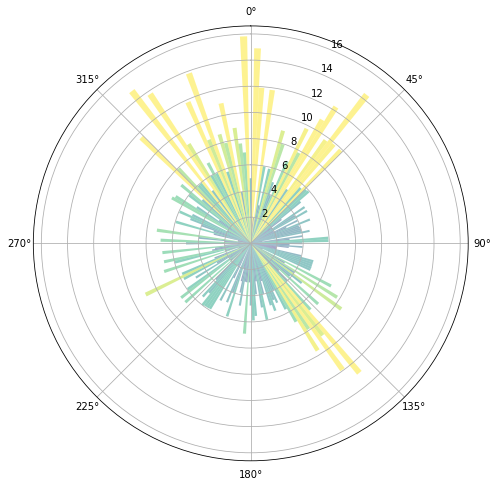

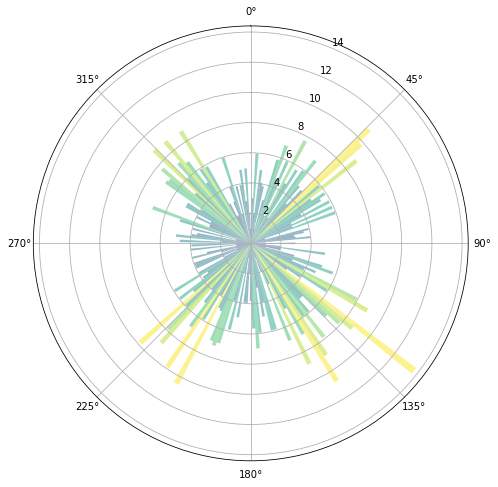

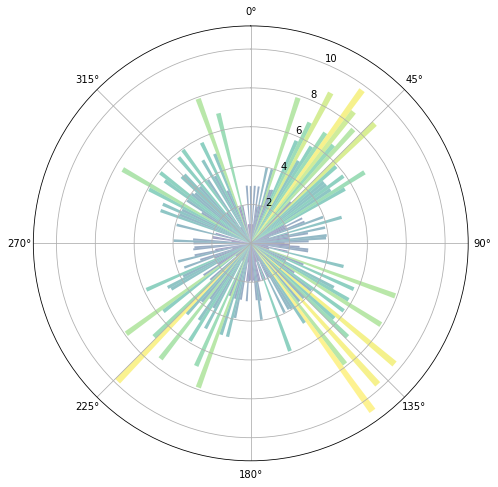

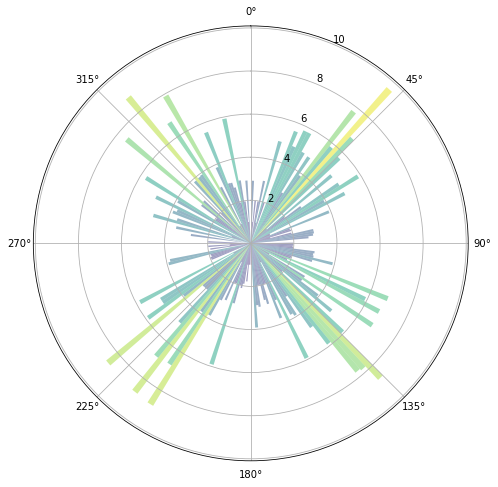

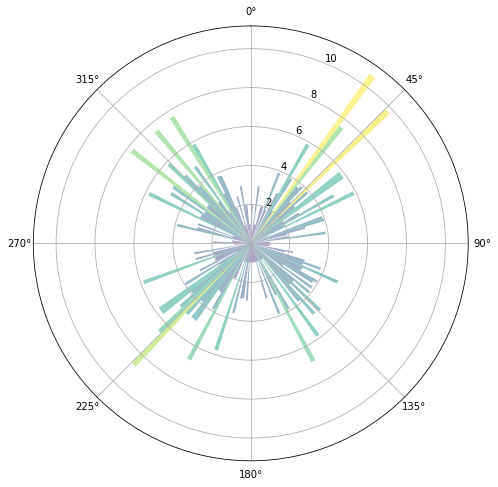

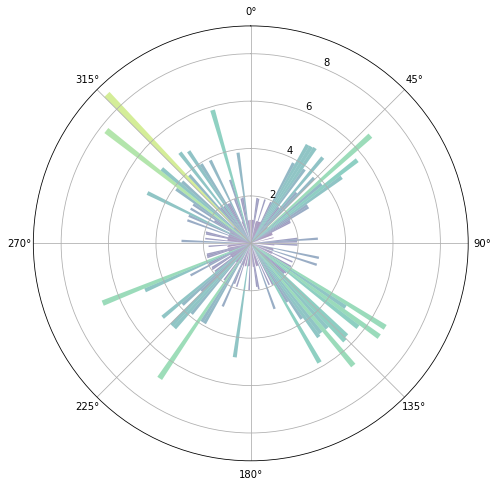

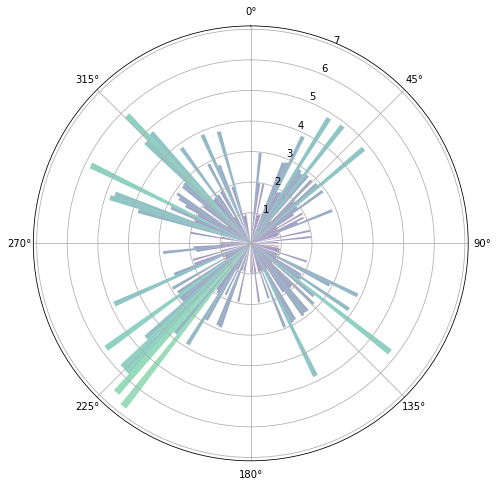

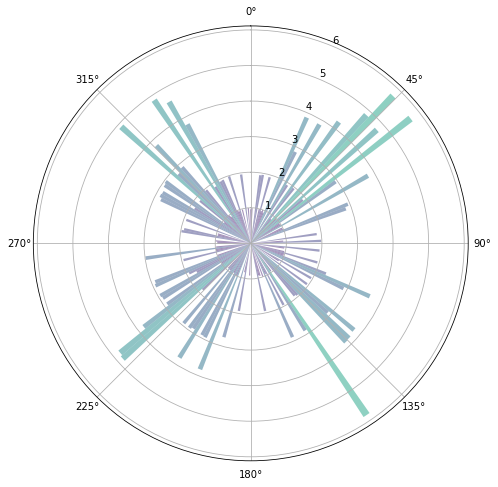

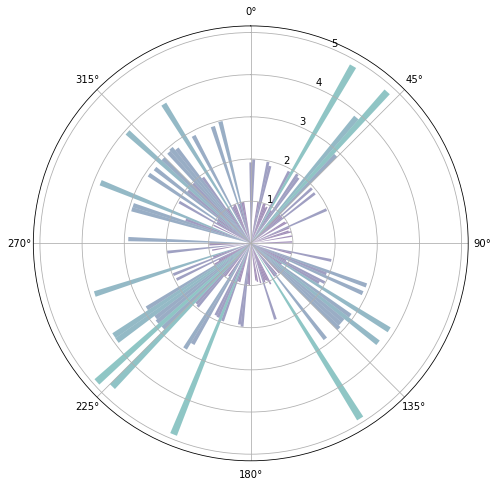

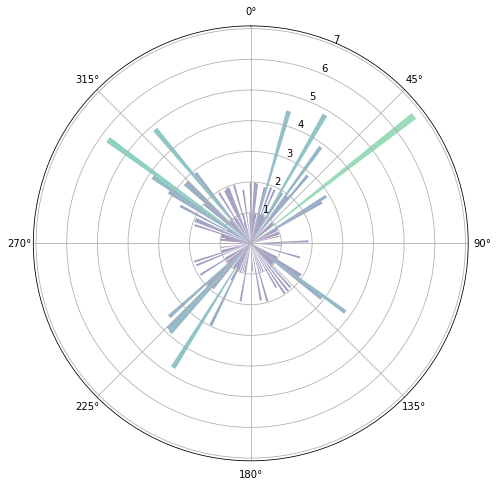

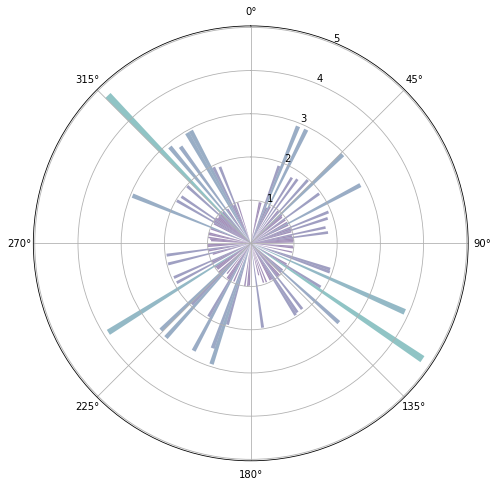

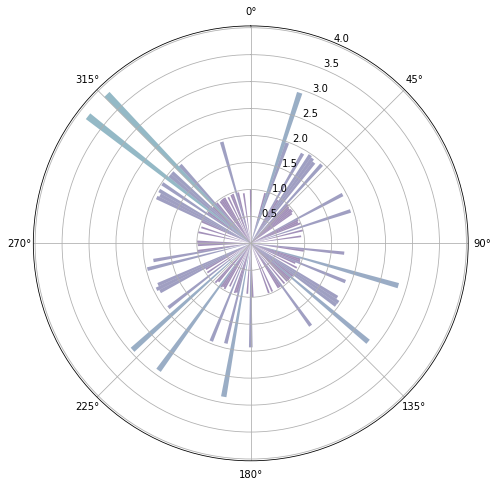

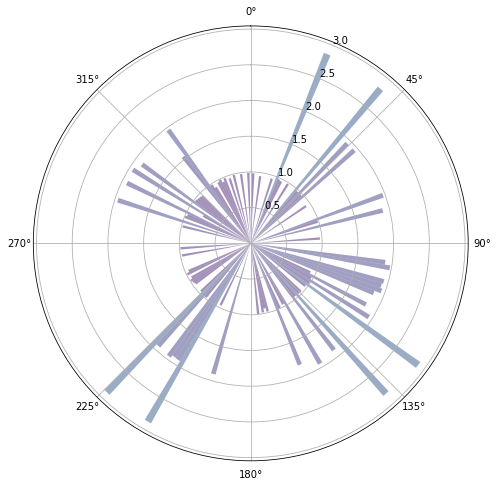

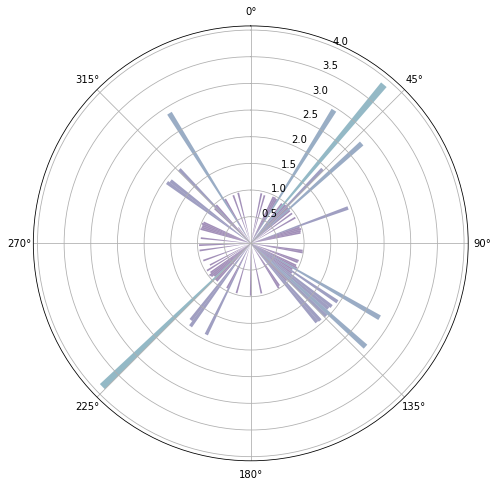

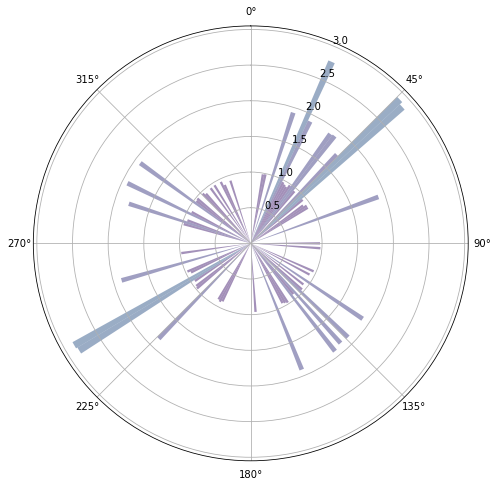

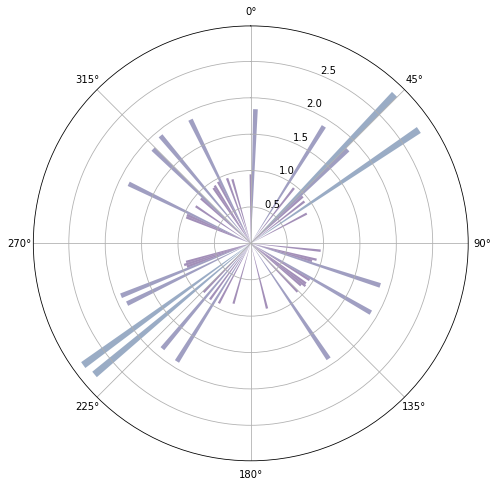

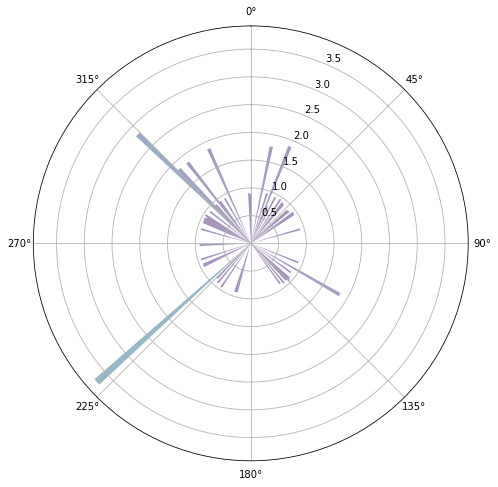

In [6]:
###################################################################
# Postprocessing step Rayleigh1
###################################################################

# Load windows from file
if love_only == False:
    save_path = save_path_ray1
    winfile = open(save_path + "windows_r.pkl","rb")
    print("open %s"%winfile)
    windows_r = pickle.load(winfile)
    winfile.close()
    windows_r.wineval = True

# Calculate means, modes, medians, standard deviations, and set weights
    windows_r.set_weights(method = wghtmethod, exp = exp)
    windows_r.calc_mean_std()
    try:
        windows_r.calc_kde_mode()
    except:
        pass
    windows_r.calc_median()

# Plot all the histograms for the individual frequencies
    try:
        windows_r.plot_histograms(savepath = save_path)
    except:
        pass


# Plot the dispersion curves with errorbars 
    try:
        windows_r.plot_errorbar(savepath = save_path)
    except:
        pass
    
# Write results to a file
    try:
        windows_r.writeresults(savepath = save_path)
    except:
        pass
# Plot the slowness and backazimuth distribution for all frequencies
    windows_r.plot_polar(savepath = save_path)
    print("\n Done Rayleigh")

Calculating means and standard deviations...

  Now at frequency f = 21.81
  Now at frequency f = 18.34
  Now at frequency f = 15.42
  Now at frequency f = 12.97
  Now at frequency f = 10.91
  Now at frequency f = 9.17
  Now at frequency f = 7.71
  Now at frequency f = 6.48
  Now at frequency f = 5.45
  Now at frequency f = 4.59
  Now at frequency f = 3.86
  Now at frequency f = 3.24
  Now at frequency f = 2.73
  Now at frequency f = 2.29
  Now at frequency f = 1.93
  Now at frequency f = 1.62
  Now at frequency f = 1.36
  Now at frequency f = 1.15
Calculating KDEs and modes:

  Now at frequency f = 20.08
  Now at frequency f = 16.88
  Now at frequency f = 14.20
  Now at frequency f = 11.94
  Now at frequency f = 10.04
  Now at frequency f = 8.44
  Now at frequency f = 7.10
  Now at frequency f = 5.97
  Now at frequency f = 5.02
  Now at frequency f = 4.22
  Now at frequency f = 3.55
  Now at frequency f = 2.98
  Now at frequency f = 2.51
  Now at frequency f = 2.11
  Now at frequency 

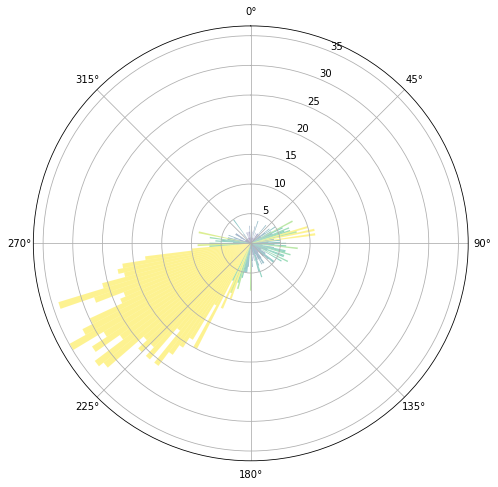

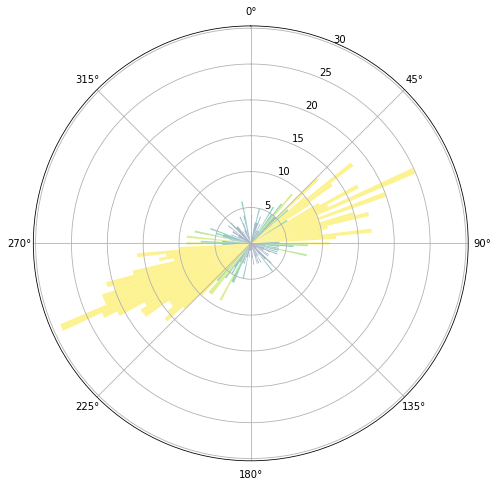

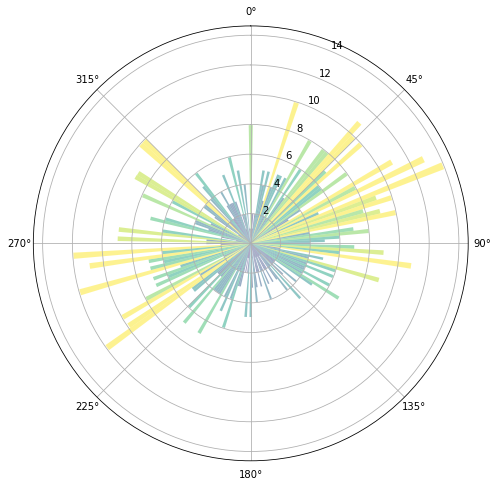

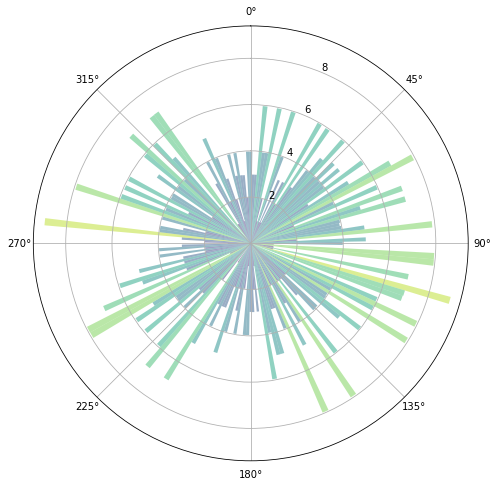

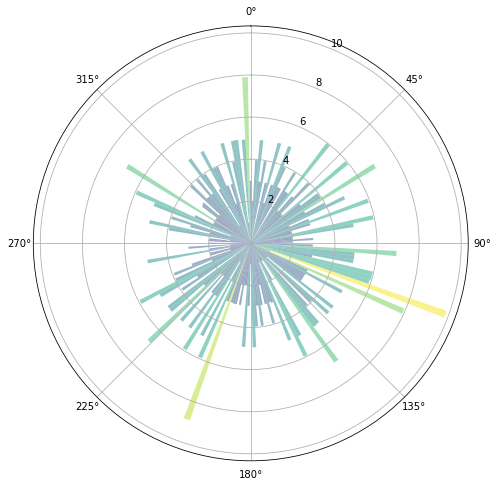

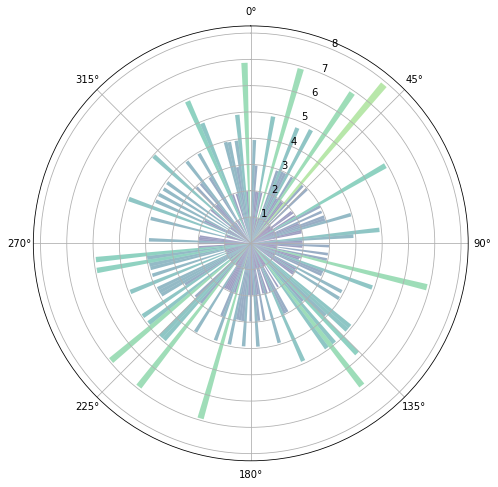

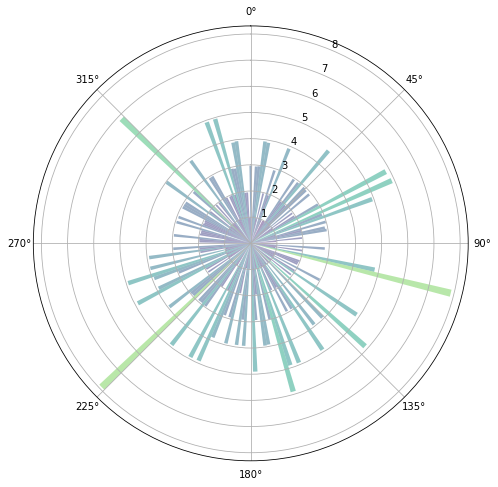

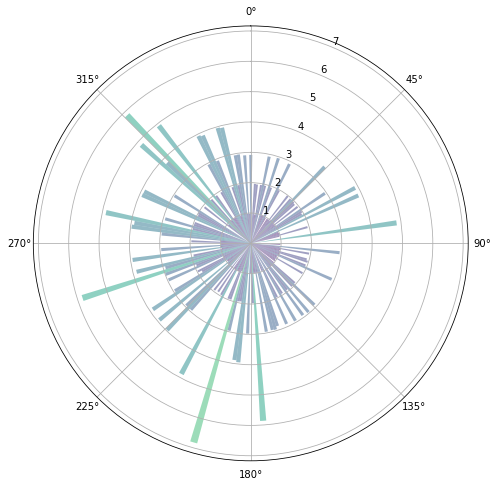

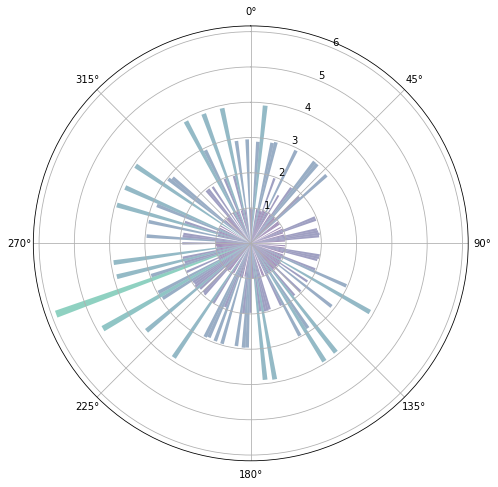

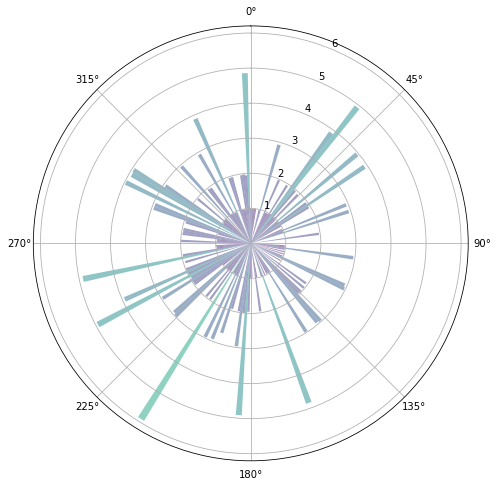

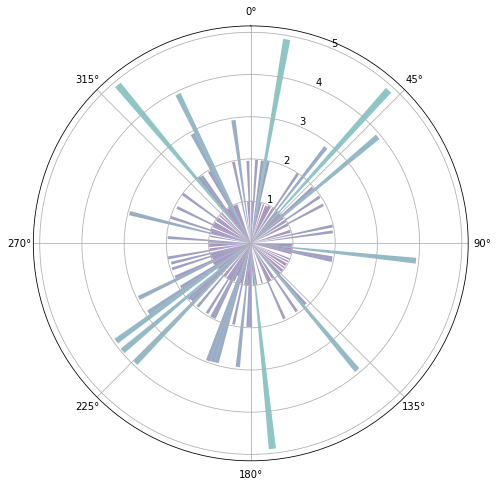

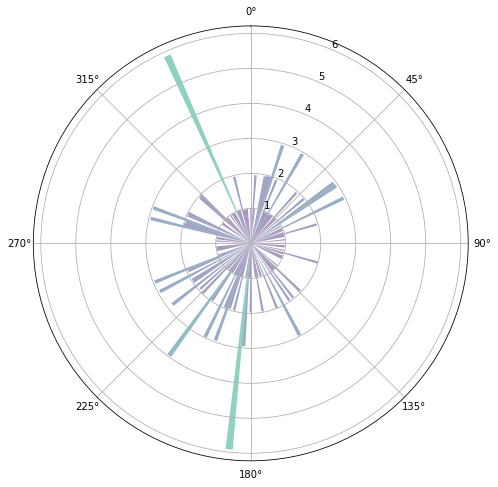

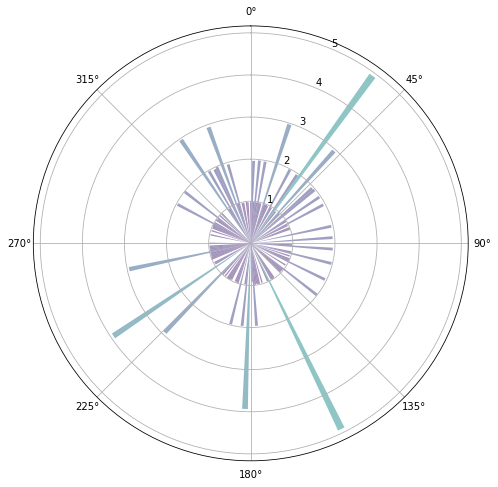

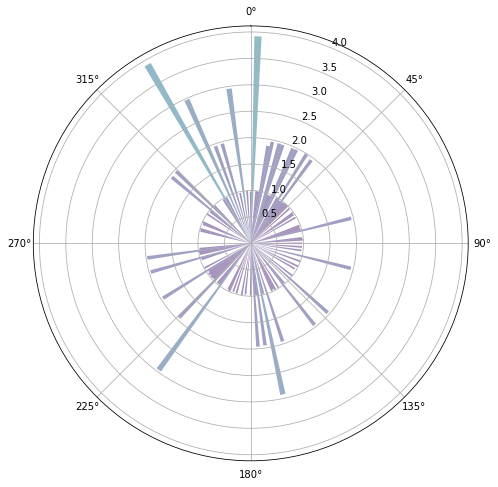

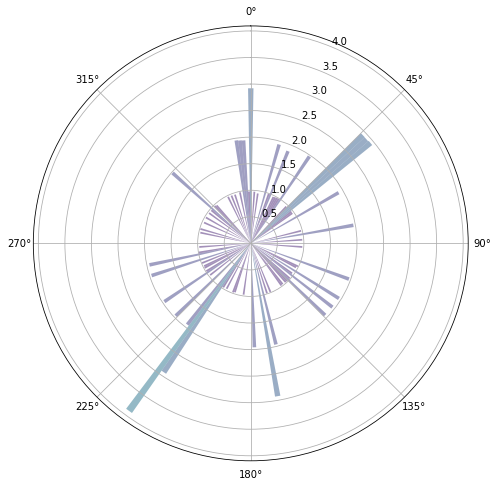

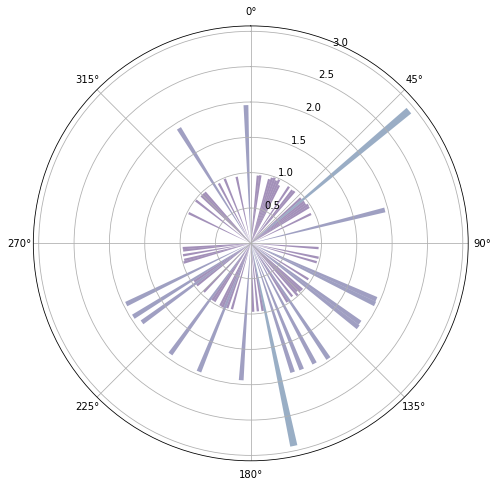

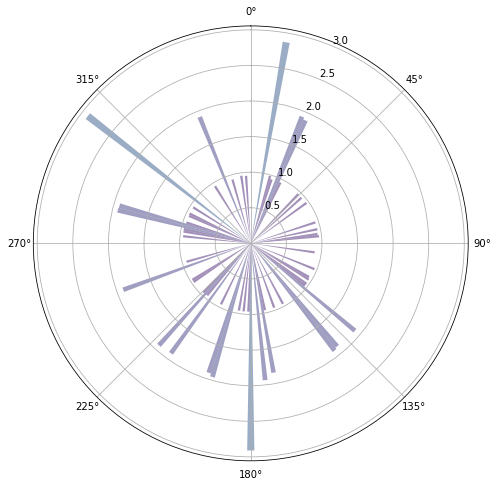

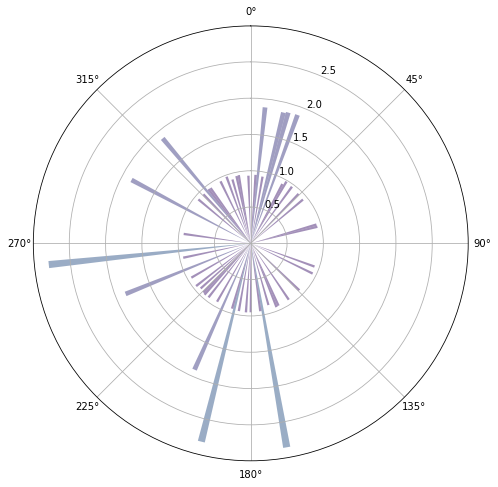

In [7]:
###################################################################
# Postprocessing step Rayleigh2 
###################################################################
if love_only == False:
    save_path = save_path_ray2
    winfile = open(save_path + "windows_r2.pkl","rb")
    windows_r2 = pickle.load(winfile)
    winfile.close()
    windows_r2.wineval = True

# Calculate means, modes, medians, standard deviations, and set weights
    windows_r2.set_weights(method = wghtmethod, exp = exp)
    windows_r2.calc_mean_std()
    windows_r2.calc_kde_mode()
    windows_r2.calc_median()

# Plot all the histograms for the individual frequencies
    windows_r2.plot_histograms(savepath = save_path)


# Plot the dispersion curves with errorbars 
    windows_r2.plot_errorbar(savepath = save_path)

# Write results to a file
    windows_r2.writeresults(savepath = save_path)

# Plot the slowness and backazimuth distribution for all frequencies
    windows_r2.plot_polar(savepath = save_path)
    print("\n Done Rayleigh2")

print("\n DONE ALL")

